In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the Online Retail dataset
file_path = r"C:\Users\Srusti\Customer-Lifetime-Value-(LTV)-Prediction\Data\OnlineRetail.csv"
retail_data = pd.read_csv(file_path, encoding='ISO-8859-1', parse_dates=['InvoiceDate'])

# Display the first few rows to understand the structure
print("Dataset Shape:", retail_data.shape)
print("\nFirst 5 rows:")
display(retail_data.head())

# Check column names and data types
print("\nColumn Information:")
print(retail_data.info())

# Check for missing values
print("\nMissing Values:")
print(retail_data.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(retail_data.describe())

# Check the date range in the dataset
print("\nDate Range:")
print(f"Start Date: {retail_data['InvoiceDate'].min()}")
print(f"End Date: {retail_data['InvoiceDate'].max()}")

# Count unique customers and transactions
print("\nUnique Values:")
print(f"Number of unique customers: {retail_data['CustomerID'].nunique()}")
print(f"Number of unique invoices: {retail_data['InvoiceNo'].nunique()}")

# Check for any negative quantities or prices (potential returns)
print("\nPotential Returns:")
print(f"Transactions with negative quantity: {(retail_data['Quantity'] < 0).sum()}")
print(f"Transactions with negative price: {(retail_data['UnitPrice'] < 0).sum()}")

# Create a year_month column for time-based analysis
retail_data['year_month'] = retail_data['InvoiceDate'].dt.to_period('M')
print("\nMonthly distribution:")
print(retail_data['year_month'].value_counts().sort_index())

Dataset Shape: (541909, 8)

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Basic Statistics:
            Quantity                    InvoiceDate      

Missing CustomerID values: 135080 (24.93%)
Dataset shape after removing missing CustomerID: (406829, 10)
Number of cancellation transactions: 8905


C:\Users\Srusti\AppData\Local\Temp\ipykernel_27320\1701786242.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_data_clean['CustomerID'] = retail_data_clean['CustomerID'].astype(int)


Regular transactions: 397924
Returns/cancellations: 8905
Transactions with zero price: 40
Transactions with extremely high prices (>1000): 46
Dataset shape after removing zero/negative prices: (406789, 10)


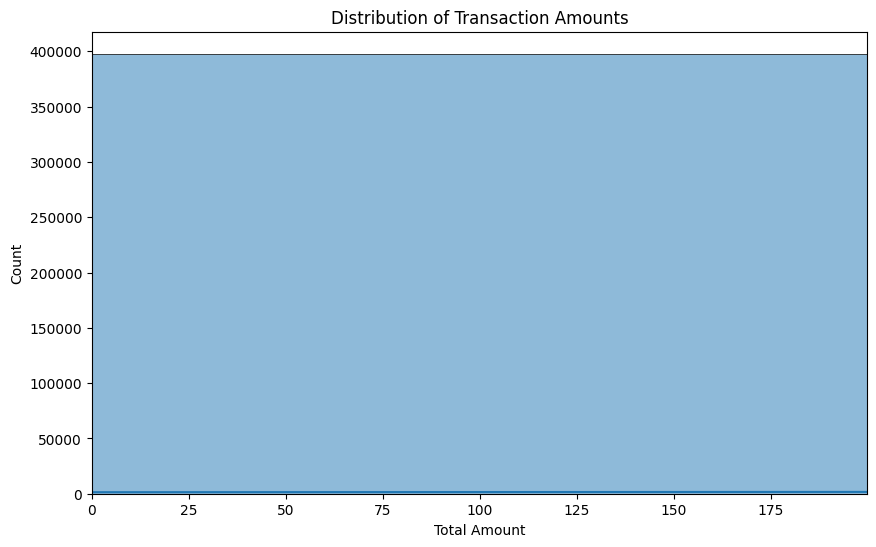

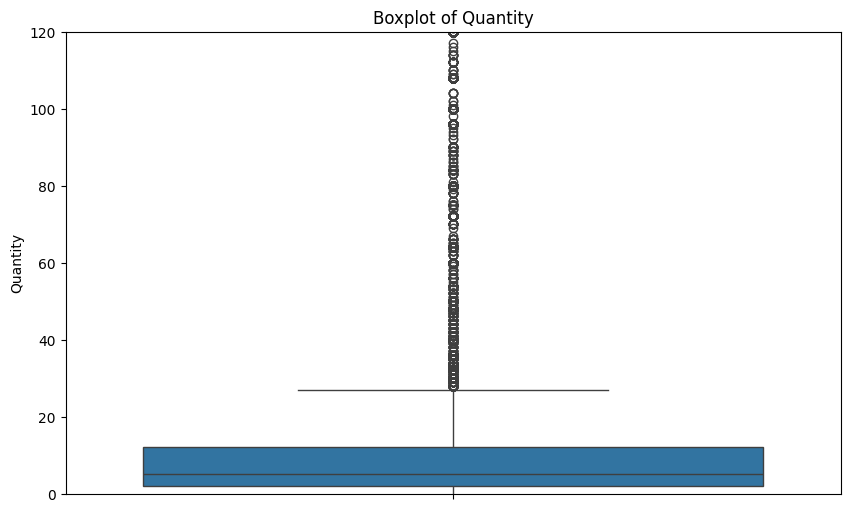


Customer Summary Statistics:
         CustomerID    total_spend  avg_order_value  num_transactions  \
count   4371.000000    4371.000000      4371.000000       4371.000000   
mean   15300.145276    1898.894032       315.976515          5.075726   
min    12346.000000   -4287.630000     -4287.630000          1.000000   
25%    13813.500000     293.785000       152.007857          1.000000   
50%    15301.000000     648.410000       237.070000          3.000000   
75%    16778.500000    1611.860000       370.832143          5.000000   
max    18287.000000  279489.020000      6207.670000        248.000000   
std     1722.310262    8220.235339       361.344569          9.332529   

       num_products                 first_purchase  \
count   4371.000000                           4371   
mean      61.222832  2011-04-28 04:36:58.352779520   
min        1.000000            2010-12-01 08:26:00   
25%       15.000000            2011-01-12 12:43:00   
50%       35.000000            2011-03-31 

In [3]:
# Step 2: Data Cleaning

# 1. Calculate the total amount for each transaction
retail_data['TotalAmount'] = retail_data['Quantity'] * retail_data['UnitPrice']

# 2. Check for missing CustomerID values
print(f"Missing CustomerID values: {retail_data['CustomerID'].isnull().sum()} ({retail_data['CustomerID'].isnull().sum() / len(retail_data) * 100:.2f}%)")

# 3. Remove transactions with missing CustomerID (as we need it for CLV prediction)
retail_data_clean = retail_data.dropna(subset=['CustomerID'])
print(f"Dataset shape after removing missing CustomerID: {retail_data_clean.shape}")

# 4. Convert CustomerID to integer type
retail_data_clean['CustomerID'] = retail_data_clean['CustomerID'].astype(int)

# 5. Identify and handle returns/cancellations (negative quantities or 'C' in InvoiceNo)
# First, let's check how many invoices start with 'C' (typically cancellations)
cancellations = retail_data_clean[retail_data_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"Number of cancellation transactions: {len(cancellations)}")

# 6. Separate regular transactions and returns for analysis
regular_transactions = retail_data_clean[~retail_data_clean['InvoiceNo'].astype(str).str.startswith('C') & (retail_data_clean['Quantity'] > 0)]
returns = retail_data_clean[(retail_data_clean['InvoiceNo'].astype(str).str.startswith('C')) | (retail_data_clean['Quantity'] < 0)]

print(f"Regular transactions: {len(regular_transactions)}")
print(f"Returns/cancellations: {len(returns)}")

# 7. Check for any anomalies in prices
print(f"Transactions with zero price: {(retail_data_clean['UnitPrice'] == 0).sum()}")
print(f"Transactions with extremely high prices (>1000): {(retail_data_clean['UnitPrice'] > 1000).sum()}")

# 8. Remove transactions with zero or negative prices (if appropriate for your analysis)
retail_data_clean = retail_data_clean[retail_data_clean['UnitPrice'] > 0]
print(f"Dataset shape after removing zero/negative prices: {retail_data_clean.shape}")

# 9. Examine the distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(retail_data_clean['TotalAmount'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Total Amount')
plt.xlim(0, retail_data_clean['TotalAmount'].quantile(0.99))  # Limit x-axis to 99th percentile for better visualization
plt.show()

# 10. Check for outliers in quantity
plt.figure(figsize=(10, 6))
sns.boxplot(y=retail_data_clean['Quantity'])
plt.title('Boxplot of Quantity')
plt.ylim(0, retail_data_clean['Quantity'].quantile(0.99))  # Limit y-axis to 99th percentile
plt.show()

# 11. Create a summary of transactions by customer for initial analysis
customer_summary = retail_data_clean.groupby('CustomerID').agg(
    total_spend=('TotalAmount', 'sum'),
    avg_order_value=('TotalAmount', lambda x: x.sum() / len(set(retail_data_clean.loc[x.index, 'InvoiceNo']))),
    num_transactions=('InvoiceNo', 'nunique'),
    num_products=('StockCode', 'nunique'),
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
).reset_index()

# Calculate customer lifespan in days
customer_summary['lifespan_days'] = (customer_summary['last_purchase'] - customer_summary['first_purchase']).dt.days

# Display the customer summary
print("\nCustomer Summary Statistics:")
print(customer_summary.describe())

# 12. Save the cleaned data for further analysis
retail_data_clean.to_csv('cleaned_retail_data.csv', index=False)
customer_summary.to_csv('customer_summary.csv', index=False)

print("\nData cleaning completed. Files saved: 'cleaned_retail_data.csv' and 'customer_summary.csv'")

In [6]:
# Step 3: Feature Engineering for Customer Lifetime Value Prediction

import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned datasets
retail_data = pd.read_csv('cleaned_retail_data.csv', parse_dates=['InvoiceDate'])
customer_summary = pd.read_csv('customer_summary.csv', parse_dates=['first_purchase', 'last_purchase'])

# Reference date for RFM calculation
reference_date = retail_data['InvoiceDate'].max() + timedelta(days=1)
print(f"Reference date: {reference_date}")

# --- RFM Features ---
rfm = retail_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalAmount': 'sum'                                       # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalAmount': 'Monetary'})

# --- Tenure ---
tenure = retail_data.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max']).reset_index()
tenure['Tenure'] = (tenure['max'] - tenure['min']).dt.days
rfm = rfm.merge(tenure[['CustomerID', 'Tenure']], on='CustomerID')

# --- Purchase Frequency ---
rfm['PurchaseFrequency'] = np.where(rfm['Tenure'] > 0, rfm['Frequency'] / (rfm['Tenure'] / 7), rfm['Frequency'])

# --- Average Order Value ---
total_by_invoice = retail_data.groupby(['CustomerID', 'InvoiceNo'])['TotalAmount'].sum().reset_index()
avg_order_value = total_by_invoice.groupby('CustomerID')['TotalAmount'].mean().reset_index()
avg_order_value.columns = ['CustomerID', 'AvgOrderValue']
rfm = rfm.merge(avg_order_value, on='CustomerID')

# --- Purchase Variability ---
purchase_var = total_by_invoice.groupby('CustomerID')['TotalAmount'].std().reset_index()
purchase_var.columns = ['CustomerID', 'PurchaseVariability']
purchase_var['PurchaseVariability'] = purchase_var['PurchaseVariability'].fillna(0)
rfm = rfm.merge(purchase_var, on='CustomerID')

# --- Time Between Purchases ---
def avg_time_between_purchases(cid):
    dates = sorted(retail_data[retail_data['CustomerID'] == cid]['InvoiceDate'].dt.date.unique())
    if len(dates) <= 1: return 0
    return np.mean([ (dates[i+1] - dates[i]).days for i in range(len(dates)-1) ])
rfm['AvgTimeBetweenPurchases'] = rfm['CustomerID'].apply(avg_time_between_purchases)

# --- Product Diversity ---
product_diversity = retail_data.groupby('CustomerID')['StockCode'].nunique().reset_index()
product_diversity.columns = ['CustomerID', 'ProductDiversity']
rfm = rfm.merge(product_diversity, on='CustomerID')

# --- Return Rate ---
retail_data['IsReturn'] = ((retail_data['Quantity'] < 0) | (retail_data['InvoiceNo'].astype(str).str.startswith('C'))).astype(int)
return_rate = retail_data.groupby('CustomerID')['IsReturn'].mean().reset_index()
return_rate.columns = ['CustomerID', 'ReturnRate']
rfm = rfm.merge(return_rate, on='CustomerID')

# --- Seasonality Features ---
retail_data['Quarter'] = retail_data['InvoiceDate'].dt.quarter
retail_data['Month'] = retail_data['InvoiceDate'].dt.month
quarter_features = pd.get_dummies(retail_data[['CustomerID', 'Quarter']], columns=['Quarter'], prefix='Quarter').groupby('CustomerID').max()
month_features = pd.get_dummies(retail_data[['CustomerID', 'Month']], columns=['Month'], prefix='Month').groupby('CustomerID').max()
rfm = rfm.set_index('CustomerID').join(quarter_features).join(month_features).reset_index()

# --- RFM Scores ---
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# --- Customer Segmentation ---
def segment(row):
    if row['RFM_Score'] >= 13: return 'Champions'
    if 10 <= row['RFM_Score'] < 13: return 'Loyal Customers'
    if row['R_Score'] >= 4 and (row['F_Score'] + row['M_Score'] >= 6): return 'Potential Loyalists'
    if row['R_Score'] >= 3 and (row['F_Score'] + row['M_Score'] >= 5): return 'Recent Customers'
    if row['R_Score'] <= 2 and (row['F_Score'] + row['M_Score'] >= 6): return 'At Risk Customers'
    if row['R_Score'] <= 2 and (row['F_Score'] + row['M_Score'] <= 5): return 'Hibernating'
    return 'Others'
rfm['Segment'] = rfm.apply(segment, axis=1)

# --- Frequency in Recent Time Windows ---
for days in [30, 60, 90, 180]:
    cutoff = reference_date - timedelta(days=days)
    freq = retail_data[retail_data['InvoiceDate'] >= cutoff].groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
    freq.columns = ['CustomerID', f'Frequency_{days}d']
    rfm = rfm.merge(freq, on='CustomerID', how='left')
    rfm[f'Frequency_{days}d'] = rfm[f'Frequency_{days}d'].fillna(0)

# --- Average Basket Size ---
basket_size = retail_data.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].sum().reset_index()
avg_basket = basket_size.groupby('CustomerID')['Quantity'].mean().reset_index()
avg_basket.columns = ['CustomerID', 'AvgBasketSize']
rfm = rfm.merge(avg_basket, on='CustomerID')

# --- Purchase Acceleration ---
def purchase_acceleration(cid):
    dates = sorted(retail_data[retail_data['CustomerID'] == cid]['InvoiceDate'].dt.date.unique())
    if len(dates) <= 2: return 0
    diffs = [ (dates[i+1] - dates[i]).days for i in range(len(dates)-1) ]
    mid = len(diffs)//2
    first, second = np.mean(diffs[:mid]), np.mean(diffs[mid:])
    return second / first if first > 0 else 0
rfm['PurchaseAcceleration'] = rfm['CustomerID'].apply(purchase_acceleration)

# --- Value Trend ---
def value_trend(cid):
    invoices = retail_data[retail_data['CustomerID'] == cid]
    if len(invoices) <= 1: return 0
    daily = invoices.groupby(invoices['InvoiceDate'].dt.date)['TotalAmount'].sum()
    if len(daily) <= 1: return 0
    mid = len(daily)//2
    first, second = daily.iloc[:mid].mean(), daily.iloc[mid:].mean()
    return second / first if first > 0 else 0
rfm['ValueTrend'] = rfm['CustomerID'].apply(value_trend)

# --- Customer Age ---
rfm['CustomerAge'] = (reference_date - tenure['min']).dt.days.values
# Before filling NaNs, convert categorical columns to int 
for col in ['R_Score', 'F_Score', 'M_Score']:
    if pd.api.types.is_categorical_dtype(rfm[col]):
        rfm[col] = rfm[col].astype(int)


# --- Finalize and Save ---
rfm = rfm.fillna(0)
rfm.to_csv('rfm_features.csv', index=False)

# --- Visualizations ---
plt.figure(figsize=(20, 15))
features = [
    ('Recency', 'Recency Distribution'),
    ('Frequency', 'Frequency Distribution'),
    ('Monetary', 'Monetary Distribution'),
    ('Tenure', 'Customer Tenure Distribution'),
    ('AvgOrderValue', 'Average Order Value Distribution'),
    ('PurchaseVariability', 'Purchase Variability Distribution')
]
for i, (col, title) in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(rfm[col], kde=True)
    plt.title(title)
    if col in ['Monetary', 'AvgOrderValue', 'PurchaseVariability']:
        plt.xlim(0, rfm[col].quantile(0.95))

plt.subplot(3, 3, 7)
sns.countplot(x='Segment', data=rfm)
plt.xticks(rotation=45)
plt.title('Customer Segments')

plt.subplot(3, 3, 8)
sns.scatterplot(x='Recency', y='Monetary', hue='Segment', data=rfm, alpha=0.6)
plt.xlim(0, rfm['Recency'].quantile(0.95))
plt.ylim(0, rfm['Monetary'].quantile(0.95))
plt.title('Recency vs Monetary by Segment')

plt.subplot(3, 3, 9)
sns.scatterplot(x='Frequency', y='Monetary', hue='Segment', data=rfm, alpha=0.6)
plt.xlim(0, rfm['Frequency'].quantile(0.95))
plt.ylim(0, rfm['Monetary'].quantile(0.95))
plt.title('Frequency vs Monetary by Segment')

plt.tight_layout()
plt.savefig('rfm_visualizations.png')
plt.show()

# --- Correlation Analysis ---
plt.figure(figsize=(14, 12))
corr = rfm.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('feature_correlation.png')
plt.show()

print("Feature engineering completed. Features saved to 'rfm_features.csv'.")
print(f"Total features: {rfm.shape[1]}")
print("Feature columns:")
for col in rfm.columns:
    print(f"- {col}")

Reference date: 2011-12-10 12:50:00


TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first